###                             ****  Mobile Price Predictions ****

### OBJECTIVE:
We are going to predict the mobile price of user choices brand with recomended features(that will fix later) with help of the dataset containing price of various type of mobile phones.
We use different types of Regression models in Machine learning and among these models, we will choose one of them having minimum mean squared error i.e, best performing models on our dataset, for future price prediction on specific brand.

### ABOUT DATASET:
The dataset is a collection of mobile phones from different brands, with different specifications and price ranges. It can be used for analysis, comparison, or recommendation purposes in the mobile phone industry. Here's a breakdown of the columns:

Unnamed: 0: This is an index or identifier for each entry in the dataset.

Brand:The brand name of the mobile phone.

Ratings: The user ratings for the mobile phone on a scale of 1 to 5.

RAM: The amount of RAM (Random Access Memory) in the mobile phone, usually measured in gigabytes (GB).

ROM: The amount of ROM (Read-Only Memory) or storage capacity in the mobile phone, usually measured in gigabytes (GB).

Mobile_Size: The size of the mobile phone referring to the display size in inches.

Primary_Cam: The resolution of the primary camera in the mobile phone in megapixels.

Selfi_Cam: The resolution of the front or selfie camera in the mobile phone in megapixels.

Battery_Power: The battery capacity of the mobile phone in milliampere-hours (mAh).

Price: The price of the mobile phone in the local currency.

### Libraries:

In [147]:
# Common Libraries & Packages
import pandas as pd
import numpy as np
import warnings

#------------------
warnings.filterwarnings('ignore')  # Filtering warnings

# Libraries for Drawing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# Libraries and packages for sci-kit learn
from sklearn.impute import KNNImputer                                  # to impute null values
from sklearn.model_selection import train_test_split                   # to split the dataset
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score # to measure the performace of the models
from sklearn.model_selection import  cross_val_score                   # Cross validations score calculations
from sklearn.metrics import make_scorer                                # to create pipline to calculate score 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder           # to convert categorical to numerical values
from sklearn.model_selection import  KFold                             # to use cross-validation 
from sklearn.linear_model import LinearRegression                      # to perform linear regression
from sklearn.ensemble import RandomForestRegressor                     # Random forest regression
from sklearn.svm import SVR                                            # Support vector regression
from sklearn.ensemble import GradientBoostingRegressor                 # Gradient boostong regression
from xgboost import XGBRegressor                                       # Extream gradient boosting regresssion 
import xgboost as xgb
# Feature engeneering libraries
import optuna                                                          # To optimize the Hyperparametrs
from feature_engine.outliers import OutlierTrimmer                     # Trimming outliers
import category_encoders as ce                                         # Binary encoding 

#---------
import joblib                                                          # To save models in requird extensions
import pickle                                                          # To work on .pkl files

### Load Dataset:

In [2]:
# Loading dataset using cs
data = pd.read_csv('MobilePrice.csv')
data.head()

Unnamed: 0                         Brand me  Ratings  RAM    ROM  \
0           0            LG V30+ (Black, 128 )      4.3  4.0  128.0   
1           1                       I Kall K11      3.4  6.0   64.0   
2           2                     Nokia 105 ss      4.3  4.0    4.0   
3           3  Samsung Galaxy A50 (White, 64 )      4.4  6.0   64.0   
4           4       POCO F1 (Steel Blue, 128 )      4.5  6.0  128.0   

   Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  
0         6.00           48       13.0           4000  24999  
1         4.50           48       12.0           4000  15999  
2         4.50           64       16.0           4000  15000  
3         6.40           48       15.0           3800  18999  
4         6.18           35       15.0           3800  18999

### Data informations:

In [3]:
# Data Informations extractions
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     836 non-null    int64  
 1   Brand me       836 non-null    object 
 2   Ratings        805 non-null    float64
 3   RAM            829 non-null    float64
 4   ROM            832 non-null    float64
 5   Mobile_Size    834 non-null    float64
 6   Primary_Cam    836 non-null    int64  
 7   Selfi_Cam      567 non-null    float64
 8   Battery_Power  836 non-null    int64  
 9   Price          836 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 65.4+ KB


Explainations: 
There are 836 entries having columns 10 columns where some columns such as 'Ratings','RAM','ROM','Mobile_Size' and 'Selfi_cam' contains some missing values that need to be filled for further analysis.

All the columns are numerical columns except 'Unamed: 0' and 'Brand me'. 

Since we are going to predict the price of phone with some specific given features and 'Ratings' is one of the feature in our dataset but previous ratings on a  particular brand does not influence its price because price of phone generally depends on its features(like RAM,ROM, CAMERA etc.) where as ratings inspire user only.

That's why 'Unamed: 0' and 'Ratings are unnecessary features of our task, so need to be drop from dataset.

### DATA PRE-PROCESSING:

In [3]:
# Droping unnecessary columns from datset
data = data.drop(columns=['Unnamed: 0','Ratings'],axis=1)
data.head()

Brand me  RAM    ROM  Mobile_Size  Primary_Cam  \
0            LG V30+ (Black, 128 )  4.0  128.0         6.00           48   
1                       I Kall K11  6.0   64.0         4.50           48   
2                     Nokia 105 ss  4.0    4.0         4.50           64   
3  Samsung Galaxy A50 (White, 64 )  6.0   64.0         6.40           48   
4       POCO F1 (Steel Blue, 128 )  6.0  128.0         6.18           35   

   Selfi_Cam  Battery_Power  Price  
0       13.0           4000  24999  
1       12.0           4000  15999  
2       16.0           4000  15000  
3       15.0           3800  18999  
4       15.0           3800  18999

In [5]:
# Counts of phones of different brands
data['Brand me'].value_counts()

Brand me
Kechaoda A27                                  11
Jivi R21Plus                                   8
Easyfone Star                                  8
Lava 34                                        8
MTR Ferrari                                    7
                                              ..
Mi 10 (Coral Green, 256 )                      1
Nokia 2.3 (Sand, 32 )                          1
I Kall K24 New Coo of Two Mobiles              1
Huawei Y9 Prime 2019 (Sapphire Blue, 128 )     1
ITEL magic 1 max                               1
Name: count, Length: 427, dtype: int64

Explainations:
It informs us that there are many phones belongs to same root brand. We will use only root brand in our further anlysis process.

In [30]:
# Brands counts plots
brands_counts = data['Brand me'].value_counts().reset_index()
brands_counts.columns = ['Phones','Counts']
fig = px.bar(brands_counts,x='Phones',y='Counts',title='Counts of Each phones')
fig.update_xaxes(tickangle=90)
fig.show()

### Extracting Root Brand name from Brand me columns:

In [4]:
# Function to extract brand names based on the given conditions
def extract_brand_name(brand_name):
    # Split the brand name into parts
    parts = brand_name.split()
    
    # Condition 1: Extract if the first part length >= 2
    if len(parts[0]) >= 2:
        return parts[0]
    
    # Condition 2: Extract if the first part length == 1 and there are at least 2 parts
    if len(parts) >= 2 and len(parts[0]) == 1:
        return (' '.join(parts[:2])).title()  # Return first two parts combined
    
    return 'Other'  # Default if no conditions are met

In [5]:
# Applying extract_brand_name on dataset and droping 'Brand me' column
data['Brand']= data['Brand me'].apply(lambda brand: extract_brand_name(brand))
data = data.drop(columns=['Brand me'])
data.head()

RAM    ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
0  4.0  128.0         6.00           48       13.0           4000  24999   
1  6.0   64.0         4.50           48       12.0           4000  15999   
2  4.0    4.0         4.50           64       16.0           4000  15000   
3  6.0   64.0         6.40           48       15.0           3800  18999   
4  6.0  128.0         6.18           35       15.0           3800  18999   

     Brand  
0       LG  
1   I Kall  
2    Nokia  
3  Samsung  
4     POCO

In [9]:
df = data['Brand'].value_counts().reset_index()
df.columns = ['Brand','Count']
fig = px.bar(df,x='Brand',y='Count',title='Counts of Each Brand',color='Brand')
fig.update_xaxes(tickangle=90,title='Brand',tickmode='linear')
# Update layout to handle large number of x-axis labels
fig.update_layout(
    xaxis_title='Brand',
    yaxis_title='Count',
    xaxis=dict(tickangle=90),  # Rotate x-axis labels if needed
    autosize=True,  # Automatically adjust the plot size
    margin=dict(l=50, r=50, t=50, b=150)  # Adjust margins for better fit
)
fig.show()

Explainations: These plot is helpful to determine the most uses brands such as 'Samsung','I kall' and 'Apple' etc.
So the 'Brand' column will give the significant impact on the price of a  phone of specific brand.

### Misssing values checking & impute them:

In [6]:
### Missing value checking and filling them
# data.isna().sum()
# or
ms = data.isnull().sum()
ms_df = ms.reset_index()
ms_df.columns = ['Column', 'Missing Values']
ms_df

Column  Missing Values
0            RAM               7
1            ROM               4
2    Mobile_Size               2
3    Primary_Cam               0
4      Selfi_Cam             269
5  Battery_Power               0
6          Price               0
7          Brand               0

Explaination: The above table give us the informations of columns having NAN values.

These missing data are occurs either MACR or MAR forms beacuse either user did not provide the values or  missing during data transfer or missing due to agent forgot to note it.

Since the entries of RAM, ROM, Mobile Size and Selfi Camera can be considered as discrete values because every industries 
provide these features with some specific values, not all continuos values.

So, before fill up the NAN values, we determines the best possible value for them which generrally used others phones and for this mode(most frequent value) is appropriate.

### RAM and Price:

In [7]:
data[data['RAM'].isna()]

RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
28   NaN  32.0          4.5           64       23.0           3000   1599   
93   NaN  64.0          4.4           64        NaN           3500   1100   
96   NaN  64.0          2.0           64        NaN           3500   1625   
166  NaN  64.0          4.4           64        8.0           3500   1200   
351  NaN  64.0          4.4           64        NaN           3500   1346   
523  NaN  64.0          4.4           64       13.0           3500   1100   
616  NaN  64.0          4.4           64        NaN           3500   1346   

       Brand  
28      Lava  
93   Samsung  
96   Samsung  
166  Samsung  
351  Samsung  
523  Samsung  
616  Samsung

Explainations: Clearly, RAM column having brand Samsung and Lava contains NAN vales where 6 phone are from Samsung brand and 1 is from LAVA.
To impute NAN vales we compute the most frequent values having brand Samsung or LAVA and  price < 2000(approximate) as NAN values for RAM has maximum price 1625.

In [8]:
# Impute vale for RAM
ram_mode = data[(data['Price'] < 2000) & (data['Brand'].isin(['Samsung', 'Lava']))]['RAM'].mode()[0]
print("Impute value for RAM: ",ram_mode)
# Displaying such values
data[(data['Price'] < 2000) & (data['Brand'].isin(['Samsung', 'Lava']))].head(10) # showing first 10 rows

Impute value for RAM:  6.0


RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
28   NaN  32.0         4.50           64       23.0           3000   1599   
34   6.0  24.0         4.54           48        NaN           1750   1799   
49   6.0  32.0         4.54           64       14.0           2500   1695   
93   NaN  64.0         4.40           64        NaN           3500   1100   
94   3.0   NaN          NaN           64        NaN           3800   1790   
96   NaN  64.0         2.00           64        NaN           3500   1625   
121  6.0  25.0         4.54           48       12.0           3000   1369   
139  4.0   NaN         4.40           64        NaN           3500   1549   
142  6.0  24.0         4.54           48        NaN           1750   1599   
166  NaN  64.0         4.40           64        8.0           3500   1200   

       Brand  
28      Lava  
34      Lava  
49      Lava  
93   Samsung  
94   Samsung  
96   Samsung  
121     Lava  
139  Samsung  
142     Lava  
166  Samsung

### ROM and Price:

In [9]:
data[data['ROM'].isna()]

RAM  ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
94   3.0  NaN          NaN           64        NaN           3800   1790   
139  4.0  NaN         4.40           64        NaN           3500   1549   
367  8.0  NaN         4.77           48        NaN           2500   1045   
493  8.0  NaN         4.58           64        NaN           1750   1840   

        Brand  
94    Samsung  
139   Samsung  
367  Kechaoda  
493      Lava

Explainations: The impute value for ROM should be the most frequent value of ROM having brand Samsung, Lava and Kechaoda and price < 2000(approximate) as maximum price having NAN value is 1840.

In [10]:
# Impute value for ROM
rom_mode = data[(data['Price'] < 2000) & (data['Brand'].isin(['Samsung', 'Lava','Kechaoda']))]['ROM'].mode()[0]
print("Impute value for ROM: ",rom_mode)
# Displaying such values
data[(data['Price'] < 2000) & (data['Brand'].isin(['Samsung', 'Lava','Kechaoda']))].head(10) # showing first 10 rows

Impute value for ROM:  32.0


RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
16  6.0  32.0         3.70           64        NaN           4700    990   
28  NaN  32.0         4.50           64       23.0           3000   1599   
34  6.0  24.0         4.54           48        NaN           1750   1799   
49  6.0  32.0         4.54           64       14.0           2500   1695   
61  6.0  32.0         4.40           48        NaN           3000    930   
62  6.0  32.0         4.40           48        NaN           3000    930   
82  6.0  64.0         4.54           48        NaN           3600   1799   
93  NaN  64.0         4.40           64        NaN           3500   1100   
94  3.0   NaN          NaN           64        NaN           3800   1790   
96  NaN  64.0         2.00           64        NaN           3500   1625   

       Brand  
16  Kechaoda  
28      Lava  
34      Lava  
49      Lava  
61  Kechaoda  
62  Kechaoda  
82  Kechaoda  
93   Samsung  
94   Samsung  
96   Samsung

### Mobile Size and Price:

In [11]:
data[data['Mobile_Size'].isnull()]

RAM  ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
94   3.0  NaN          NaN           64        NaN           3800   1790   
120  6.0  2.4          NaN           48        NaN           3000   1190   

       Brand  
94   Samsung  
120    Micax

In [12]:
# Impute for Mobile_Size
Size_mode = data[(data['Price'] < 2000) & (data['Brand'].isin(['Samsung', 'Micax']))]['Mobile_Size'].mode()[0]
print("Impute value for Mobile Size: ",Size_mode)
# Displaying such values
data[(data['Price'] < 2000) & (data['Brand'].isin(['Samsung', 'Micax']))].head(10) # showing first 10 rows

Impute value for Mobile Size:  4.54


RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
23    6.0  32.0         4.54           25       23.0           3000   1240   
36    6.0  32.0         4.54           48       18.0           1750   1549   
44    6.0  32.0         4.77           48        NaN           1750   1451   
92   12.0  56.0         4.57           48       10.0           3000   1799   
93    NaN  64.0         4.40           64        NaN           3500   1100   
94    3.0   NaN          NaN           64        NaN           3800   1790   
96    NaN  64.0         2.00           64        NaN           3500   1625   
104   4.0  20.0         4.54           48        NaN           3700   1499   
120   6.0   2.4          NaN           48        NaN           3000   1190   
123   4.0  40.0         4.58           48        8.0           3800   1799   

       Brand  
23     Micax  
36     Micax  
44     Micax  
92     Micax  
93   Samsung  
94   Samsung  
96   Samsung  
104    Micax  
120    Micax  
123    Micax

### Selfi_Cam and Price:

In [13]:
data[data['Selfi_Cam'].isnull()]

RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
12    2.0  16.0         5.50            8        NaN           4200   5498   
16    6.0  32.0         3.70           64        NaN           4700    990   
20    8.0  64.0         4.54           64        NaN           2500   1199   
22    6.0  32.0         4.54           48        NaN           3000   1349   
26   12.0  24.0         2.00           64        NaN           1550   1690   
..    ...   ...          ...          ...        ...            ...    ...   
823   6.0  32.0         4.54           64        NaN           2500   1695   
826   6.0  32.0         4.52           48        NaN           3500   2599   
830   6.0  32.0         4.50           48        NaN           3000    898   
832   8.0  64.0         4.54           64        NaN           2500   1390   
834  10.0  32.0         4.50           64        NaN           3500    799   

        Brand  
12   Wizphone  
16   Kechaoda  
20    InFocus  
22    Karbonn  
26    Blacear  
..        ...  
823      Lava  
826  Easyfone  
830   InFocus  
832   InFocus  
834      JIVI  

[269 rows x 8 columns]

In [14]:
# Impute for selfi camera
max_price = data[data['Selfi_Cam'].isnull()]['Price'].max() # Maximum price
bms = data[data['Selfi_Cam'].isnull()]['Brand'].unique() # brand having missing selfi camera
Selfi_mode = data[(data['Price'] < max_price) & (data['Brand'].isin(bms))]['Selfi_Cam'].mode()[0]
print("Impute value for selfi camera: ",Selfi_mode)
# Displaying such values
data[(data['Price'] < max_price) & (data['Brand'].isin(bms))].head(10) # showing first 10 rows

Impute value for selfi camera:  8.0


RAM    ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
1   6.0   64.0         4.50           48       12.0           4000  15999   
2   4.0    4.0         4.50           64       16.0           4000  15000   
3   6.0   64.0         6.40           48       15.0           3800  18999   
8   4.0  128.0         6.53           48        2.0           4020  16490   
10  6.0   32.0         4.54           64        8.0           4100   1099   
11  6.0   32.0         4.50           64        8.0           1050   1299   
12  2.0   16.0         5.50            8        NaN           4200   5498   
13  6.0   32.0         4.70           64        8.0           3000   3999   
16  6.0   32.0         3.70           64        NaN           4700    990   
19  2.0   32.0         6.20           38        2.0           4230  12990   

       Brand  
1     I Kall  
2      Nokia  
3    Samsung  
8       OPPO  
10     Megus  
11      Jmax  
12  Wizphone  
13  Easyfone  
16  Kechaoda  
19      OPPO

### Filling Missing Values:

In [15]:
# Filling NA using mode
columns_to_impute = ['RAM', 'ROM', 'Mobile_Size', 'Selfi_Cam']  # columns that need to be filled
# mode dictionary 
mode_dict = {'RAM': ram_mode, 'ROM': rom_mode,'Mobile_Size': Size_mode,'Selfi_Cam': Selfi_mode}
# Filling missing values
for col in columns_to_impute:
    data[col].fillna(mode_dict[col],inplace=True)

# Displaying dataset
data.head()


RAM    ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
0  4.0  128.0         6.00           48       13.0           4000  24999   
1  6.0   64.0         4.50           48       12.0           4000  15999   
2  4.0    4.0         4.50           64       16.0           4000  15000   
3  6.0   64.0         6.40           48       15.0           3800  18999   
4  6.0  128.0         6.18           35       15.0           3800  18999   

     Brand  
0       LG  
1   I Kall  
2    Nokia  
3  Samsung  
4     POCO

In [16]:
# checking missing values
ms = data.isnull().sum()
ms_df = ms.reset_index()
ms_df.columns = ['Column', 'Missing Values']
ms_df

Column  Missing Values
0            RAM               0
1            ROM               0
2    Mobile_Size               0
3    Primary_Cam               0
4      Selfi_Cam               0
5  Battery_Power               0
6          Price               0
7          Brand               0

Explaination: This table ensure us that our dataset does not have null values now.

### EDA: Exploratory Data Analysis

In [17]:
### Describe of each numerical features:
df = data.iloc[:,:-1]
df.describe()

RAM         ROM  Mobile_Size  Primary_Cam   Selfi_Cam  \
count  836.000000  836.000000   836.000000   836.000000  836.000000   
mean     6.065789   64.218182     5.594752    47.983254    9.210526   
std      2.519714   53.366485     3.894336    11.170093    5.419299   
min      0.000000    0.000000     2.000000     5.000000    0.000000   
25%      6.000000   32.000000     4.500000    48.000000    8.000000   
50%      6.000000   35.000000     4.735000    48.000000    8.000000   
75%      6.000000   64.000000     6.300000    48.000000   12.000000   
max     34.000000  256.000000    44.000000    64.000000   61.000000   

       Battery_Power         Price  
count     836.000000     836.00000  
mean     3274.688995   18220.34689  
std       927.518852   52805.55022  
min      1020.000000     479.00000  
25%      3000.000000     984.75000  
50%      3000.000000    1697.00000  
75%      3800.000000   18999.00000  
max      6000.000000  573000.00000

Explainations: The above table give us the clear informations of mean, median, quartiles and min, max values.
Since for any phone RAM and ROM can't be 0 but selfi camera resolution might be 0 and it need to be checked, is it actual feature of the phone or missing data?

But one thing is observable is that Mobile Size has outliers of size more than 40 inches, which is impossible and not acceptable.
So, we replace it by mode  by considering as wrong entries.

In [18]:
# Entries having Selfi Camera value as 0
data[data['Selfi_Cam'] == 0].head()

RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
41   6.0  32.0         4.54           38        0.0           1200    945   
245  6.0  32.0         4.50           48        0.0           1050    849   
255  6.0  32.0         4.54           48        0.0           3000   1200   
460  6.0  32.0         4.54           38        0.0           1200    945   
530  6.0  32.0         4.54           38        0.0           1200    945   

     Brand  
41   Inovu  
245  Forme  
255   Jivi  
460  Inovu  
530  Inovu

In [19]:
# Showing simmilar entries
bzs = data[data['Selfi_Cam'] == 0]['Brand'].unique() # brands with zero selfi camera
data[(data['Selfi_Cam'] != 0) & (data['Price'] < 1000) & (data['Brand'].isin(bzs))]

RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
40    6.0  32.0         4.54           38        8.0           1200    945   
46    1.0  16.0         4.50           48        8.0           3000    798   
47    1.0  16.0         4.50           48        2.0           3000    869   
86    6.0  32.0         4.77           48        8.0           3000    785   
91    5.0  32.0         4.54           48        8.0           3000    999   
172   6.0  32.0         4.77           48        8.0           3500    735   
227  12.0  15.0         4.50           35        8.0           2800    899   
415   0.0  64.0         4.54           64        8.0           3500    949   
459   6.0  32.0         4.54           38       20.0           1200    945   
464   1.0  16.0         4.50           48        8.0           3000    869   
465   1.0  16.0         4.50           48        8.0           3000    798   
517   5.0  32.0         4.54           48        8.0           3000    999   
529   6.0  32.0         4.54           38       20.0           1200    945   
536   1.0  16.0         4.50           48        8.0           3000    869   
537   1.0  16.0         4.50           48        8.0           3000    798   
547   6.0  32.0         4.54           64       20.0           3500    949   
791   1.0  16.0         4.50           48        8.0           3000    869   
792   1.0  16.0         4.50           48        8.0           3000    798   
799   6.0  32.0         4.54           64       20.0           3500    949   
819   6.0  32.0         4.54           64       20.0           3500    949   

     Brand  
40   Inovu  
46    Jivi  
47    Jivi  
86   Inovu  
91    Jivi  
172  Inovu  
227  Forme  
415   Jivi  
459  Inovu  
464   Jivi  
465   Jivi  
517   Jivi  
529  Inovu  
536   Jivi  
537   Jivi  
547   Jivi  
791   Jivi  
792   Jivi  
799   Jivi  
819   Jivi

Explaination: It ensure that the 0 entries for selfi camera are missing data and hence need to be filled up.

In [20]:
# Entries having RAM value as 0
data[data['RAM'] == 0].head()

RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
183  0.0  64.0         4.50           48        8.0           3000    595   
415  0.0  64.0         4.54           64        8.0           3500    949   

       Brand  
183  Callbar  
415     Jivi

In [21]:
# Showing simmilar entries
bzr = data[data['RAM'] == 0]['Brand'].unique() # brands with 0 ram
data[(data['RAM'] != 0) & (data['Price'] < 1000) & (data['Brand'].isin(bzr))]

RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
46   1.0  16.0         4.50           48        8.0           3000    798   
47   1.0  16.0         4.50           48        2.0           3000    869   
91   5.0  32.0         4.54           48        8.0           3000    999   
464  1.0  16.0         4.50           48        8.0           3000    869   
465  1.0  16.0         4.50           48        8.0           3000    798   
517  5.0  32.0         4.54           48        8.0           3000    999   
536  1.0  16.0         4.50           48        8.0           3000    869   
537  1.0  16.0         4.50           48        8.0           3000    798   
547  6.0  32.0         4.54           64       20.0           3500    949   
791  1.0  16.0         4.50           48        8.0           3000    869   
792  1.0  16.0         4.50           48        8.0           3000    798   
799  6.0  32.0         4.54           64       20.0           3500    949   
819  6.0  32.0         4.54           64       20.0           3500    949   

    Brand  
46   Jivi  
47   Jivi  
91   Jivi  
464  Jivi  
465  Jivi  
517  Jivi  
536  Jivi  
537  Jivi  
547  Jivi  
791  Jivi  
792  Jivi  
799  Jivi  
819  Jivi

Explainations: Simillarly RAM with 0 entries are also missing informations and need to be filled up.

In [22]:
# Entries having ROM value as 0
data[data['ROM'] == 0].head()

RAM  ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
190  30.0  0.0          4.5           64        8.0           3500    799   

    Brand  
190  JIVI

Explainations: According to the previous table it is clear that ROM with 0 entries is a missing values.

Againg, it is observed that the mode values for each featutures having zero values are the appropriate to replace 0 and hence we will repalce 0 by modes at next step.

### Mobile_Size and Price:

In [23]:
# Mobile having size > 40
data[data['Mobile_Size'] > 40]

RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
160  6.0  32.0         44.0           48        8.0           3000    890   
207  6.0  64.0         44.0           48        8.0           3500    899   
242  6.0  64.0         44.0           48        8.0           3500    899   
363  6.0  32.0         44.0           48        5.0           3000    970   
423  6.0  32.0         44.0           48       15.0           3000    935   
424  6.0  32.0         44.0           48       15.0           3000    970   
425  6.0  32.0         44.0           48       15.0           3000    940   
628  6.0  32.0         44.0           48        8.0           3000    970   

        Brand  
160     GAMMA  
207    I Kall  
242    I Kall  
363  Kechaoda  
423  Kechaoda  
424  Kechaoda  
425  Kechaoda  
628  Kechaoda

In [24]:
b40s = data[data['Mobile_Size'] > 40]['Brand'].unique() # brands having > 40 mobile size
Ms_mode = data[(data['Price'] < 1000) & (data['Brand'].isin(b40s))]['Mobile_Size'].mode()[0] # Mobile Size mode
print('display size mode to impute: ',Ms_mode)
data[(data['Price'] < 1000) & (data['Brand'].isin(b40s))].head(10)

display size mode to impute:  4.5


RAM   ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
16   6.0  32.0          3.7           64        8.0           4700    990   
29   8.0  32.0          4.5           48        8.0           3000    649   
61   6.0  32.0          4.4           48        8.0           3000    930   
62   6.0  32.0          4.4           48        8.0           3000    930   
107  6.0  64.0          4.5           48        8.0           3000    649   
110  6.0  32.0          4.8           48        8.0           3000    940   
124  6.0  64.0          4.5           48        8.0           3000    639   
125  6.0  64.0          4.5           48        8.0           3000    639   
128  6.0  64.0          4.5           48       12.0           3000    639   
152  6.0  64.0          4.5           64        8.0           3500    539   

        Brand  
16   Kechaoda  
29     I Kall  
61   Kechaoda  
62   Kechaoda  
107    I Kall  
110     GAMMA  
124    I Kall  
125    I Kall  
128    I Kall  
152    I Kall

In [25]:
# Replace entries having 0 RAM,ROM and Selfi_Cam by mode
data['RAM'].replace(0, ram_mode, inplace = True)
data['ROM'].replace(0, rom_mode,inplace = True)
data['Selfi_Cam'].replace(0,Selfi_mode,inplace = True)

# Replace display size having size 44 inches.
data['Mobile_Size'].replace(44,Ms_mode,inplace=True)

# Describe 
data.describe()

RAM         ROM  Mobile_Size  Primary_Cam   Selfi_Cam  \
count  836.000000  836.000000   836.000000   836.000000  836.000000   
mean     6.080144   64.256459     5.216762    47.983254    9.258373   
std      2.502126   53.331834     0.950211    11.170093    5.372829   
min      1.000000    2.000000     2.000000     5.000000    1.000000   
25%      6.000000   32.000000     4.500000    48.000000    8.000000   
50%      6.000000   35.000000     4.700000    48.000000    8.000000   
75%      6.000000   64.000000     6.260000    48.000000   12.000000   
max     34.000000  256.000000     7.000000    64.000000   61.000000   

       Battery_Power         Price  
count     836.000000     836.00000  
mean     3274.688995   18220.34689  
std       927.518852   52805.55022  
min      1020.000000     479.00000  
25%      3000.000000     984.75000  
50%      3000.000000    1697.00000  
75%      3800.000000   18999.00000  
max      6000.000000  573000.00000

### Distributions of each features:

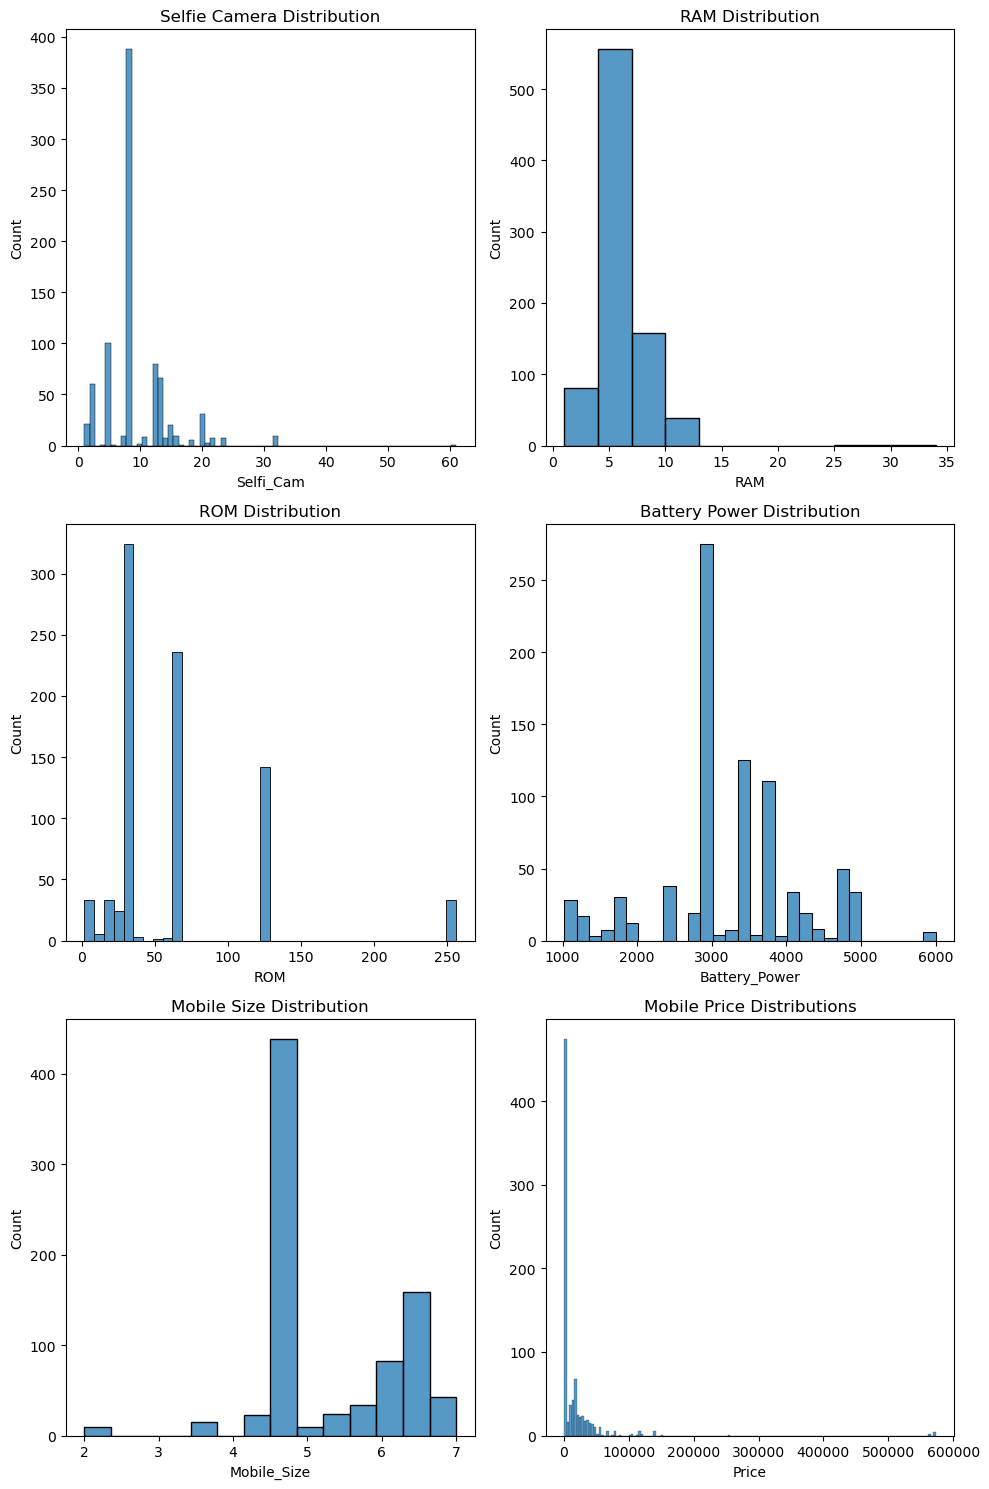

In [106]:
# Columns to plot
columns = ['Selfi_Cam','RAM', 'ROM', 'Battery_Power', 'Mobile_Size','Price']
titles = ['Selfie Camera Distribution', 'RAM Distribution',
          'ROM Distribution', 'Battery Power Distribution', 'Mobile Size Distribution','Mobile Price Distributions']

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and plot
for i, col in enumerate(columns):
    sns.histplot(data[col], ax=axes[i])
    axes[i].set_title(titles[i])
# Adjust layout
plt.tight_layout()
plt.show()

### Explainations: 
The above histograms of each features give us the following details:

1. Most of the phones have selfi camera of resolution  less than 20 megapixels, but some of them have more than 20 also.
   Having range [1,70) and dense around 10

2. RAM of each phone clouds at 5 GB and some of phone have 6 GB to 10 GB also. Having range [1,35).

3. ROM distribution is very discrete,most of the phones have ROM less than 150 GB but some have more than 250 and dense around 30-35 GB. Having range [1,260).

4. Battery power distribution is very wide, generally it dense arount 3000 mAh. Having range [1000,6000] mAh.

5. Mobile Size generally less than 10 inch . Having range [2,7].

6. Mobile Price distribution is postively skewed, but most have price less than 1 lakhs.


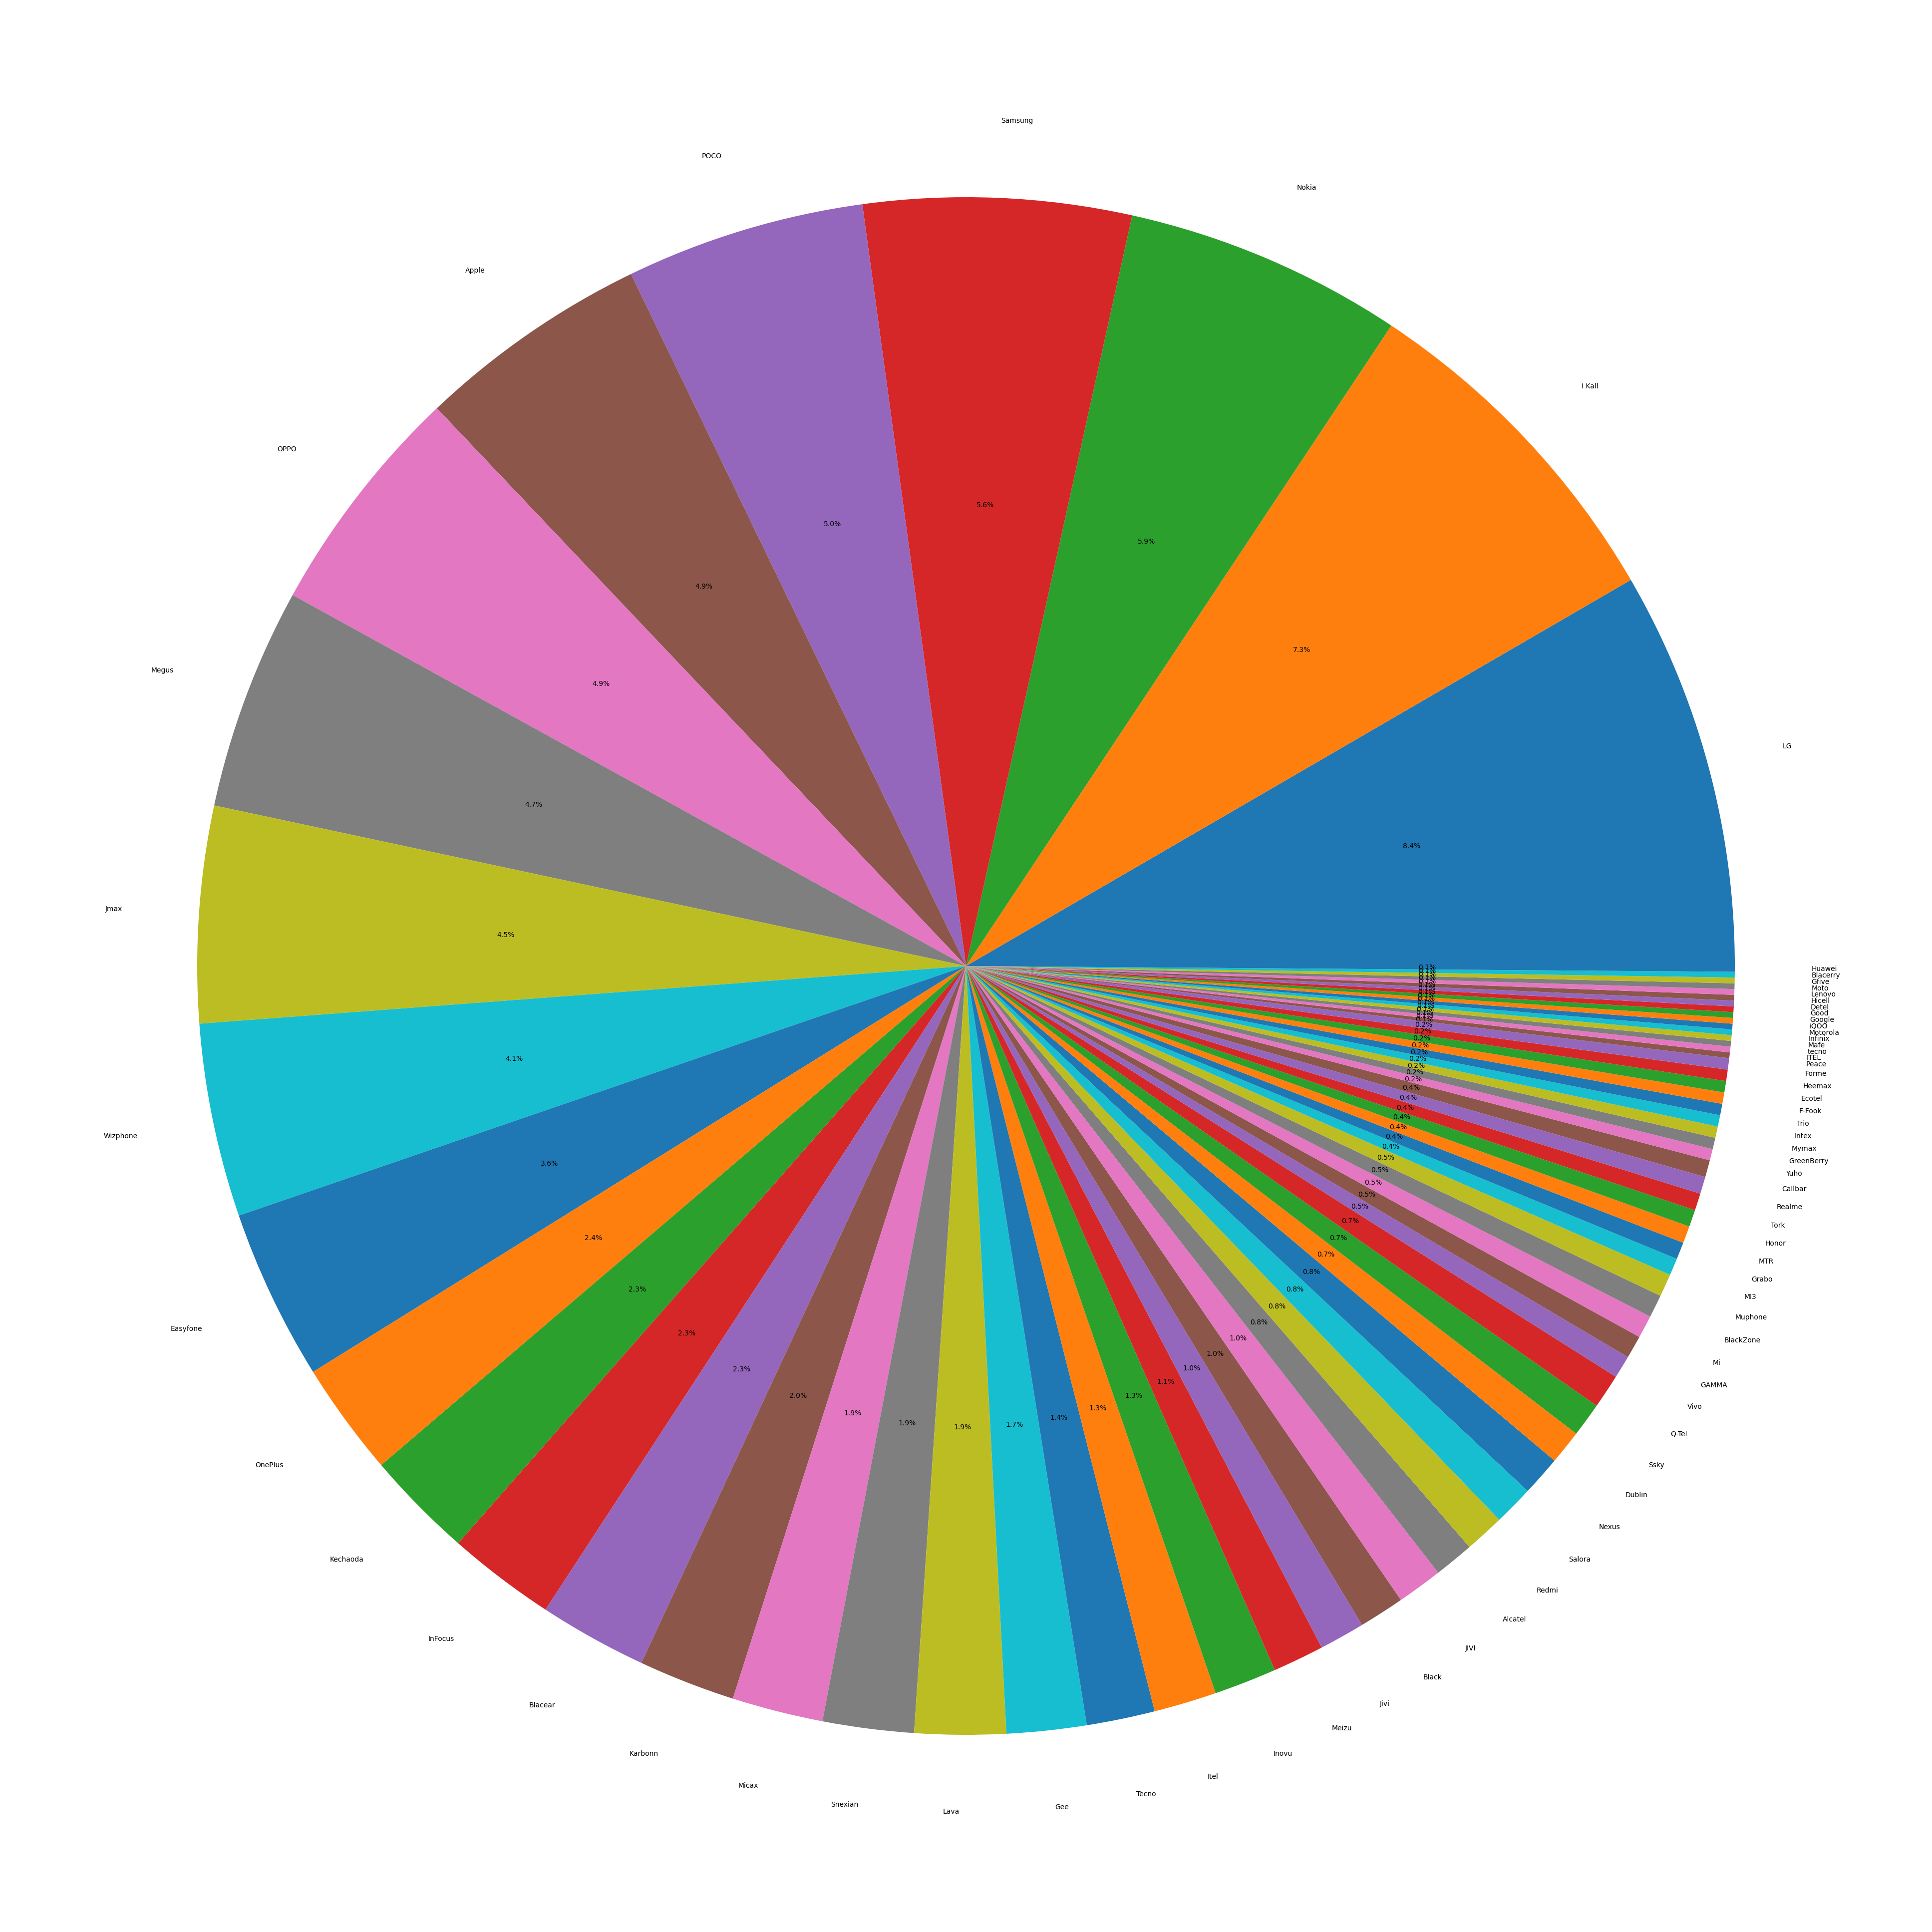

In [87]:
# Pie plots on MainBrand
plt.figure(figsize=(50,50))
plt.pie(x=data['Brand'].value_counts(),labels=data['Brand'].unique(),autopct='%1.1f%%')
plt.title = 'Brand Distribution'
plt.show()

Explainations: The above pie plots gives the brand distributions. It showing us that LG, Samsung, I kall,Nokia,
OPPO,Apple,POCO etc. are the most popular brands wheres as others are rare uses brand, that is Brand distribution is also skewed and may be considered as long-tailed distribution.

### Outliers:

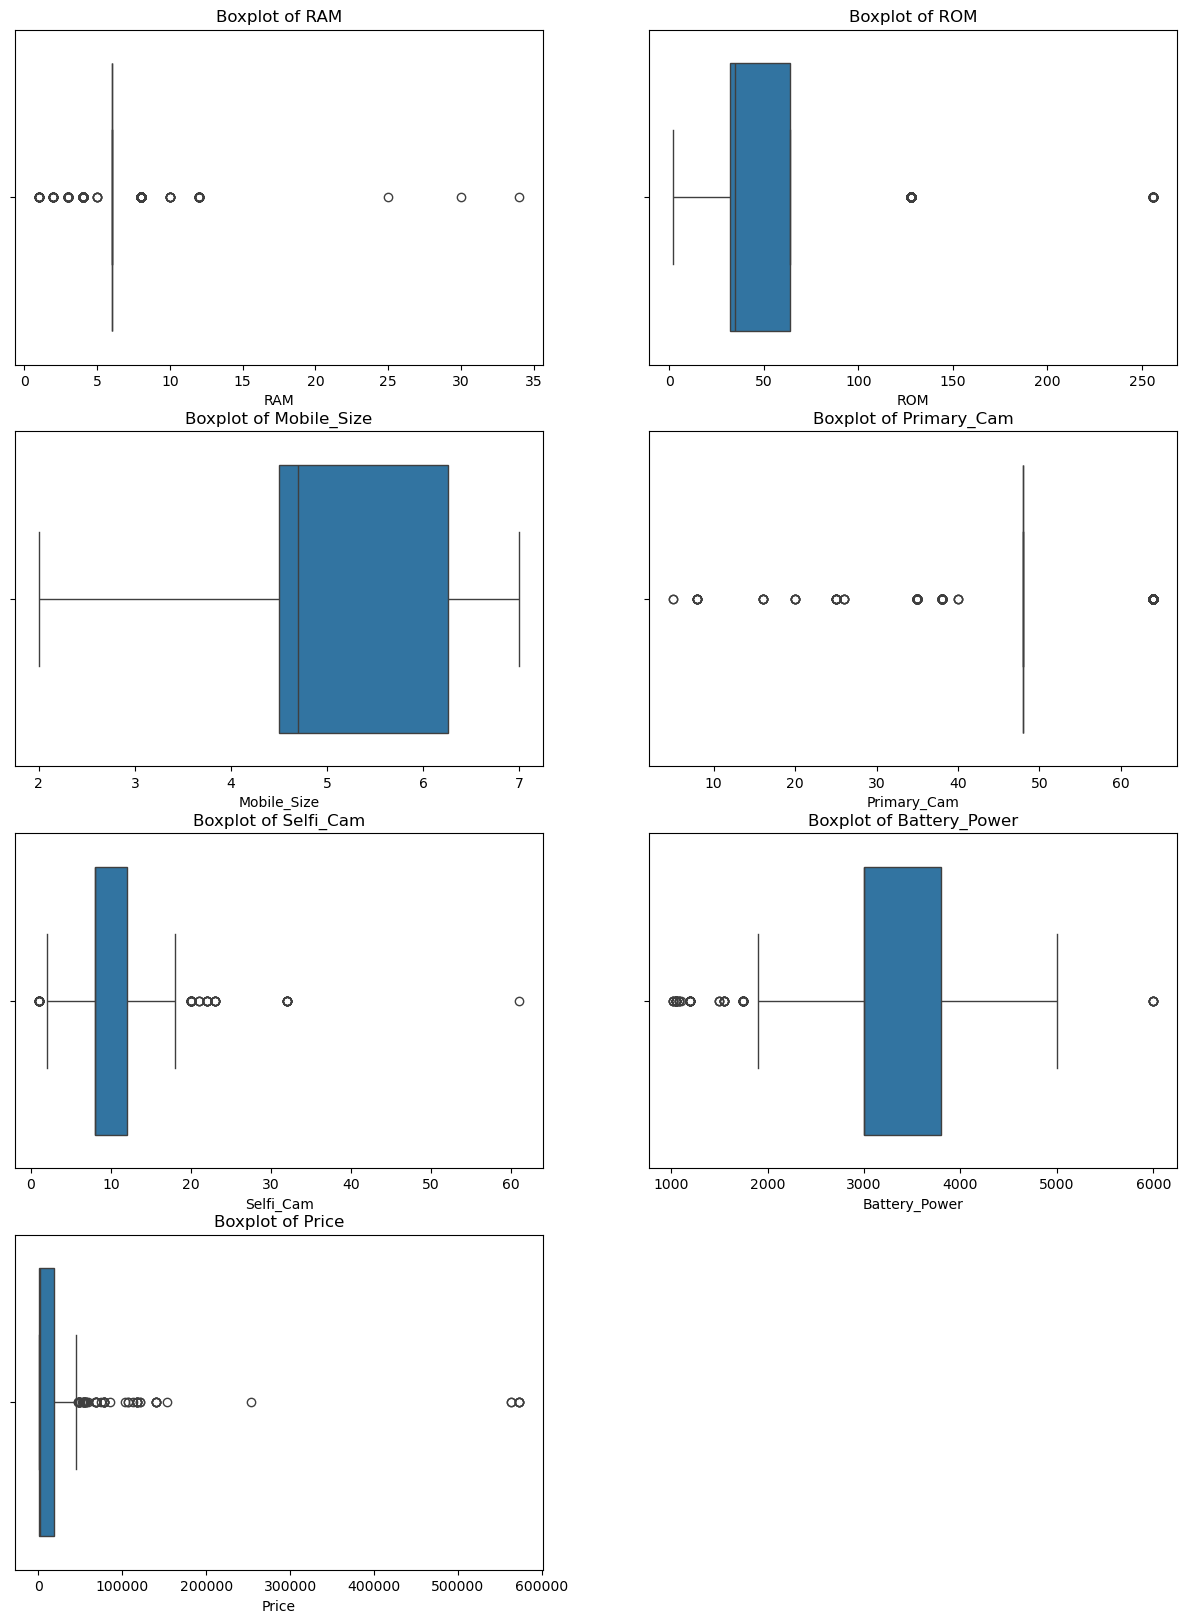

In [25]:
columns = data.columns
# Creating Subplots 
fig,axes = plt.subplots(nrows=4,ncols=2,figsize = (15,20))
# Flatten the axes
ax = axes.flatten()
for i,col in enumerate(columns):
    if col != 'Brand':
       sns.boxplot(data=data,x=col,ax=ax[i])
       ax[i].set_title(f'Boxplot of {col}')
ax[len(columns)-1].axis('off')
fig.show()


Explainations: The above box plots of each features ensure that the distributions of each features except RAM are skewed and contains too many outliers. Also it is shown that the spreadness of RAM and primary camera is too less,  mostly dense around 6GB and 47-48 MegaPixel respectively.

Too many outliers for each features describes the variability of phones, beacuse depends on various features of phones, its price always varies. 

Many phone brand industries lauch various features and fix their prices. So, outliers for our dataset is expected.



### Scatter plot of Price v/s others:

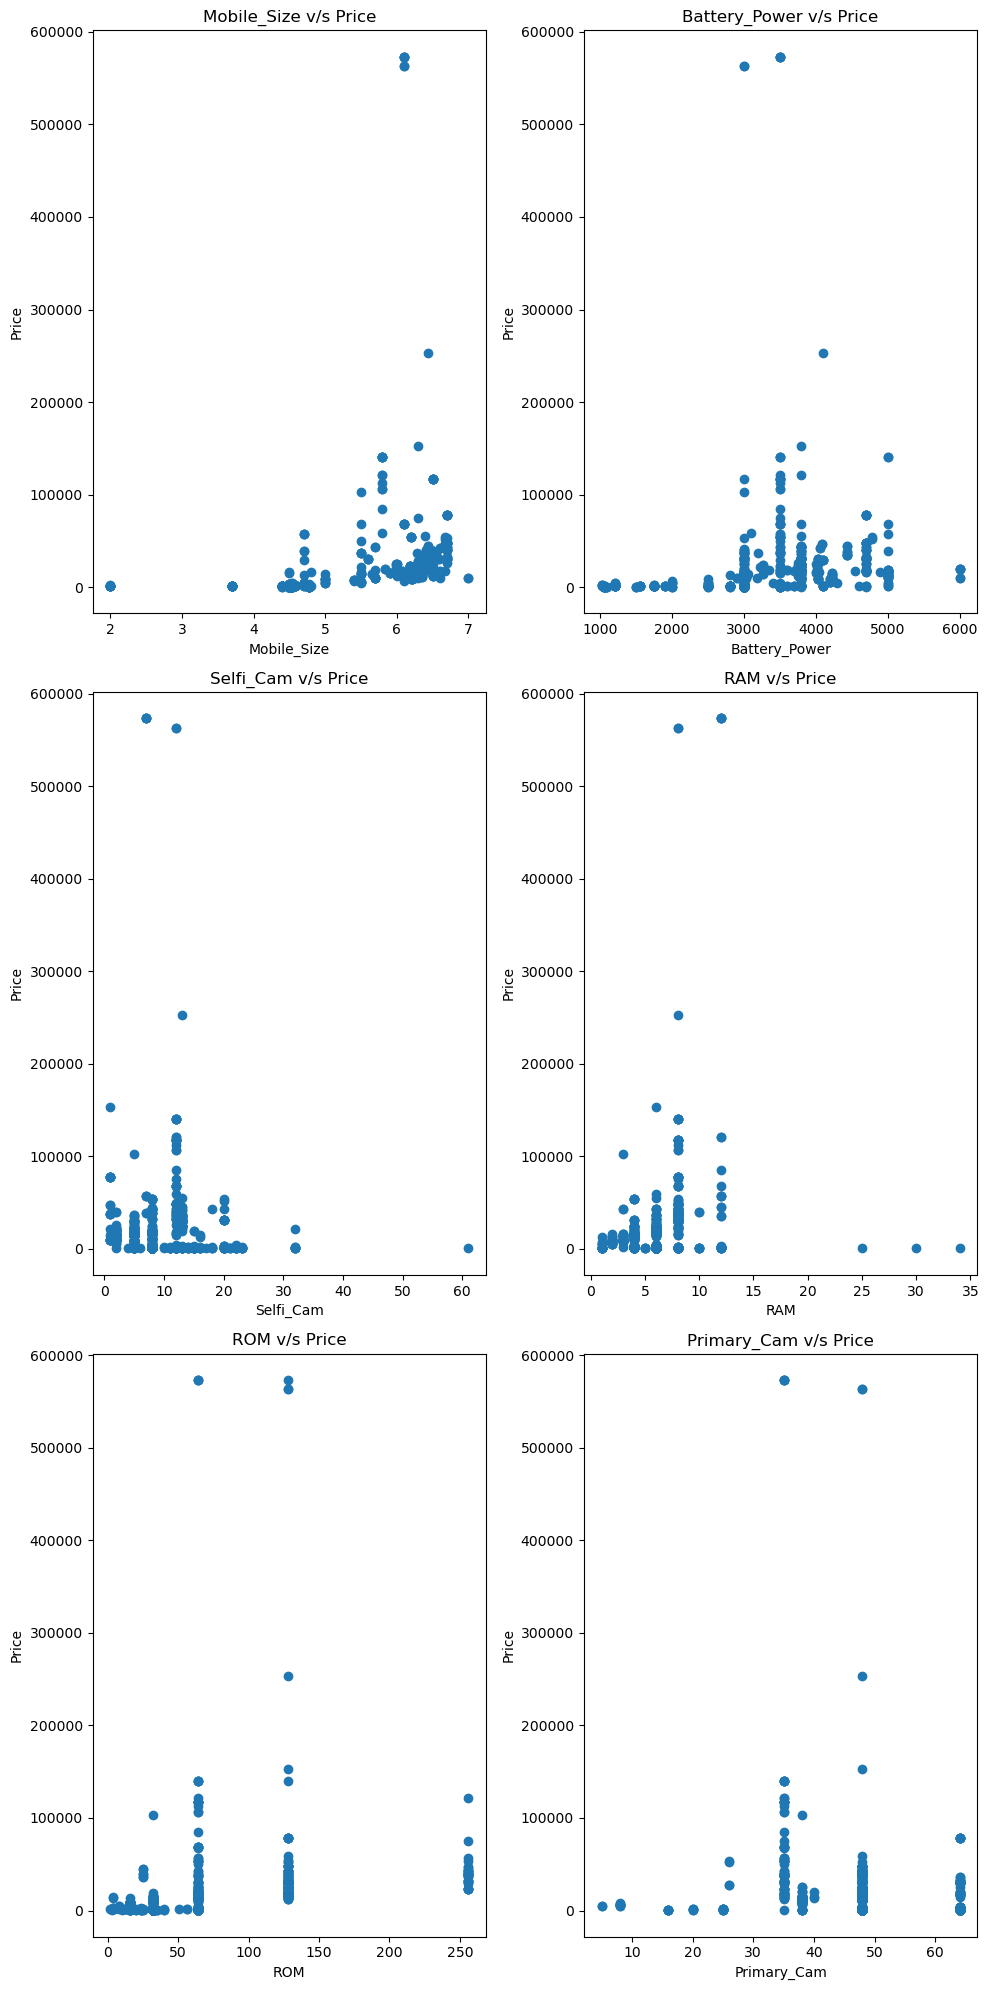

In [110]:
features = ['Mobile_Size', 'Battery_Power', 'Selfi_Cam', 'RAM', 'ROM', 'Primary_Cam']
titles = [
    'Mobile_Size v/s Price', 
    'Battery_Power v/s Price', 
    'Selfi_Cam v/s Price', 
    'RAM v/s Price', 
    'ROM v/s Price', 
    'Primary_Cam v/s Price'
]

fig, axes = plt.subplots(3, 2, figsize=(10, 20))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for ax, feature, title in zip(axes, features, titles):
    ax.scatter(data=data, x=feature, y='Price')
    ax.set_xlabel(feature)
    ax.set_ylabel('Price')
    ax.set_title(title)

# Hide the empty subplot if any
if len(features) < len(axes):
    for i in range(len(features), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

Explainations: The above scatter plots of price v/s other features shows that there is not much linear relationship between price and others features. 

### Cor-relation:

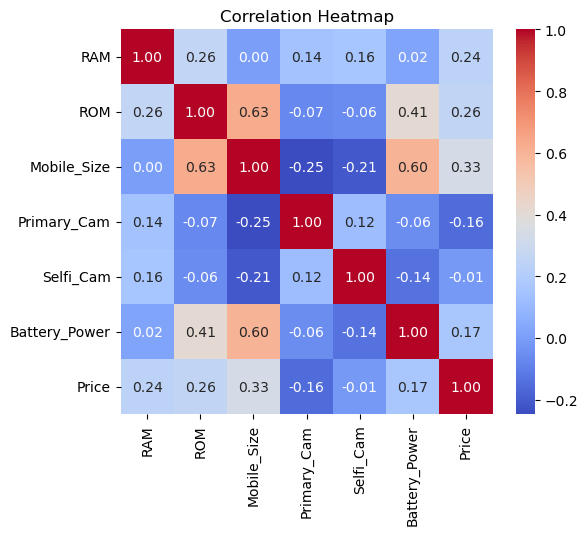

In [26]:
# Plot heatmap with correlation values
df = data.iloc[:,:7]
plt.figure(figsize=(6, 5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Explainations: The above correlation matrix is the strong informations about the non-linearity relationship between price and others features.

### Feature Engeneering:

Since there is non-linearity relationship between price and others features, so we will be more focused on non-linear
regressor model than linear regressor, in such case we generally use tree based regressor model like RandomForestRegressor,
GradientBoostingRegressor, XgbRegressor etc.
For tree based regressor model, it is not required to standarize or normalized the features vectors.

However, if it is requird to use linear regression model with some appropriate transformoation (like Logarithmic, square etc.), we need to standarize training features vectors during feeding the tarining set into regressor model.

Another thing, we already observe that target variable entries are very large, so reduce the complexity of computations,
we need to convert ach entry of the target variable to a scale of per 1 lakh.

### Handling Categorical Features:

### One-Hot encoding:

In [27]:
# Initialize the OneHotEncoder
onehot = OneHotEncoder(sparse_output=False)  # Set sparse_output to False to get a dense array

# Fit and transform the 'MainBrand' column
encoded_brands = onehot.fit_transform(data[['Brand']])

# Create a DataFrame with the encoded columns using class names as feature names
encoded_df = pd.DataFrame(encoded_brands, columns=onehot.categories_[0])

# Display the encoded DataFrame
encoded_df.head()
# Concatenate the encoded columns with the original DataFrame
hot_data = pd.concat([data.drop('Brand', axis=1), encoded_df], axis=1)

hot_data.head()

RAM    ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Price  \
0  4.0  128.0         6.00           48       13.0           4000  24999   
1  6.0   64.0         4.50           48       12.0           4000  15999   
2  4.0    4.0         4.50           64       16.0           4000  15000   
3  6.0   64.0         6.40           48       15.0           3800  18999   
4  6.0  128.0         6.18           35       15.0           3800  18999   

   Alcatel  Apple  Blacear  ...  Snexian  Ssky  Tecno  Tork  Trio  Vivo  \
0      0.0    0.0      0.0  ...      0.0   0.0    0.0   0.0   0.0   0.0   
1      0.0    0.0      0.0  ...      0.0   0.0    0.0   0.0   0.0   0.0   
2      0.0    0.0      0.0  ...      0.0   0.0    0.0   0.0   0.0   0.0   
3      0.0    0.0      0.0  ...      0.0   0.0    0.0   0.0   0.0   0.0   
4      0.0    0.0      0.0  ...      0.0   0.0    0.0   0.0   0.0   0.0   

   Wizphone  Yuho  iQOO  tecno  
0       0.0   0.0   0.0    0.0  
1       0.0   0.0   0.0    0.0  
2       0.0   0.0   0.0    0.0  
3       0.0   0.0   0.0    0.0  
4       0.0   0.0   0.0    0.0  

[5 rows x 78 columns]

# Binary Encoding:

In [164]:
# Extract features and target variable
features = data.drop(columns=['Price'])
target = data['Price']

In [172]:
# Initialize binary encoder
encoder = ce.BinaryEncoder(cols=['Brand'])

# Fit and transform the features (excluding 'Price')
be_data = encoder.fit_transform(features)

# Concatenate the encoded features with the target variable
be_data = pd.concat([be_data, target.reset_index(drop=True)], axis=1)

# Display encoded daat
be_data.head()

RAM    ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Brand_0  \
0  4.0  128.0         6.00           48       13.0           4000        0   
1  6.0   64.0         4.50           48       12.0           4000        0   
2  4.0    4.0         4.50           64       16.0           4000        0   
3  6.0   64.0         6.40           48       15.0           3800        0   
4  6.0  128.0         6.18           35       15.0           3800        0   

   Brand_1  Brand_2  Brand_3  Brand_4  Brand_5  Brand_6  Price  
0        0        0        0        0        0        1  24999  
1        0        0        0        0        1        0  15999  
2        0        0        0        0        1        1  15000  
3        0        0        0        1        0        0  18999  
4        0        0        0        1        0        1  18999

In [175]:
# Saving Binary Encoder
joblib.dump(encoder, 'Binary_Encoder.pkl')

['Binary_Encoder.pkl']

### Spliting the dataset:

In [29]:
# One-hot encoded data splits
X_hot = hot_data.drop(columns = ['Price'])
Y_hot = hot_data['Price'] /100000
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(X_hot, Y_hot, test_size = 0.2, random_state = 42)
# Binary encoded data splits
X_be = be_data.drop(columns = ['Price'])
Y_be = be_data['Price'] /100000
X_train_be, X_test_be, y_train_be, y_test_be = train_test_split(X_be, Y_be, test_size = 0.2, random_state = 42)


### Class of models:

Due to large non-linearity present in our dataset, we are going to use tree based regressor models with default corresponding hyperparametrs and based on the initial results, we choose our appropriate models and using optimize tunning approch, we will fix the hyperparametrs and use models on future predictions.

In [29]:
class RegressorModels:
    def __init__(self, X_train, X_test, y_train, y_test):
        # Define models
        self.models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'SVR': SVR(),
            'GBR': GradientBoostingRegressor(),
            'XGBoost': XGBRegressor()
        }
        
        # Store the training and testing data
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        # Initialize a DataFrame to hold results
        self.results_df = pd.DataFrame(columns=['Model', 'Train R2', 'Test R2', 'MSE'])

    def fit_and_evaluate(self) -> pd.DataFrame:
        # Fit models and compute metrics
        results_list = []
        
        for name, model in self.models.items():
            model.fit(self.X_train, self.y_train)
            y_train_pred = model.predict(self.X_train)
            y_test_pred = model.predict(self.X_test)

            train_r2 = r2_score(self.y_train, y_train_pred)
            test_r2 = r2_score(self.y_test, y_test_pred)
            mse = mean_squared_error(self.y_test, y_test_pred)

            results_list.append({
                'Model': name,
                'Train R2': train_r2,
                'Test R2': test_r2,
                'MSE': mse
            })

        # Convert the results list to a DataFrame
        self.results_df = pd.concat([self.results_df, pd.DataFrame(results_list)], ignore_index=True)

        return self.results_df

### Model performance on One-Hot encoded data:

In [30]:
# Evaluating models performance on one hot encoded data
regressor_models = RegressorModels(X_train_hot, X_test_hot, y_train_hot, y_test_hot)
results_df = regressor_models.fit_and_evaluate()

results_df

Model  Train R2   Test R2       MSE
0  Linear Regression  0.402287  0.173575  0.192142
1      Random Forest  0.953775  0.863558  0.031722
2                SVR  0.041215  0.058338  0.218934
3                GBR  0.955787  0.749155  0.058321
4            XGBoost  0.978318  0.968118  0.007413

### Model performace on Binary Encoded data:

In [31]:
# Evaluating models performance on one hot encoded data
regressor_models = RegressorModels(X_train_be, X_test_be, y_train_be, y_test_be)
results_df = regressor_models.fit_and_evaluate()

results_df

Model  Train R2   Test R2       MSE
0  Linear Regression  0.233738  0.156804  0.196041
1      Random Forest  0.953281  0.860392  0.032458
2                SVR  0.040725  0.058139  0.218980
3                GBR  0.956996  0.905511  0.021968
4            XGBoost  0.978326  0.866285  0.031088

Explainations: On both the encoded case of categorical feature, we see that Random Forest, Gradient Boosting and Extrem Gradient Boosting Regressors models performs well, however there are some overfitting cases and we will solve overfitting using hyperparametrs tuning approach.

### HyperParameters Tuning:

### Using One-Hot Encoding:

### Spliting data:

In [117]:
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(X_hot, Y_hot, test_size = 0.2, random_state = 42,shuffle=True)

### EXtreme Gradient Boosting Hyperparametrs Tuinning:

In [118]:
def objective(trial):
    params = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log = True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log = True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log = True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log = True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.012, 0.014, 0.016, 0.018]),
        'max_depth': trial.suggest_categorical('max_depth', [7, 9, 11, 13, 15]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'n_estimators': trial.suggest_int('n_estimators', 5, 1000),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
    }    
    
    regressor = XGBRegressor(**params, n_jobs = -1)
    scorer = make_scorer(r2_score)
    accuracy = cross_val_score(regressor, X_train_hot, y_train_hot, cv = 5, 
                               scoring = scorer, n_jobs = -1).mean()
    
    return accuracy

In [ ]:
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler(seed = 0))
study.optimize(objective, n_trials = 100)

In [121]:
best_params = study.best_trial.params
print(f'\nBest Params: {best_params}')
best_regressor = XGBRegressor(**best_params, n_jobs = -1)
best_regressor.fit(X_train_hot, y_train_hot)
y_pred_train = best_regressor.predict(X_train_hot)
y_pred_test = best_regressor.predict(X_test_hot)
print(f'Train R2 Score : {r2_score(y_train_hot, y_pred_train) * 100:.2f} %')
print(f'Test R2 Score  : {r2_score(y_test_hot, y_pred_test) * 100:.2f} %')


Best Params: {'lambda': 8.458971452037948, 'alpha': 0.08193722060680364, 'reg_lambda': 0.09762599247688784, 'reg_alpha': 0.361318389338293, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 772, 'gamma': 0.14694664540037505}
Train R2 Score : 91.53 %
Test R2 Score  : 78.26 %


### Random Forest hyperparametrs tuning:

In [105]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }    
    regressor = RandomForestRegressor(**params, n_jobs = -1)
    scorer = make_scorer(r2_score)
    accuracy = cross_val_score(regressor, X_train_hot, y_train_hot, cv = 5, 
                               scoring = scorer, n_jobs = -1).mean()
    
    return accuracy

In [ ]:
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler(seed = 0))
study.optimize(objective, n_trials = 100)

In [108]:
best_params = study.best_trial.params
print(f'\nBest Params: {best_params}')
best_regressor = RandomForestRegressor(**best_params, n_jobs = -1)
best_regressor.fit(X_train_hot, y_train_hot)
y_pred_train = best_regressor.predict(X_train_hot)
y_pred_test = best_regressor.predict(X_test_hot)
print(f'Train R2 Score : {r2_score(y_train_hot, y_pred_train) * 100:.2f} %')
print(f'Test R2 Score  : {r2_score(y_test_hot, y_pred_test) * 100:.2f} %')

Train R2 Score : 93.77 %
Test R2 Score  : 80.11 %


### Gradient Boosting hyperparametrs tuning:

In [123]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }    
    regressor = GradientBoostingRegressor(**params)
    scorer = make_scorer(r2_score)
    accuracy = cross_val_score(regressor, X_train_hot, y_train_hot, cv = 5, 
                               scoring = scorer, n_jobs = -1).mean()
    
    return accuracy

In [ ]:
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler(seed = 0))
study.optimize(objective, n_trials = 100)

In [125]:
best_params = study.best_trial.params
print(f'\nBest Params: {best_params}')
best_regressor = GradientBoostingRegressor(**best_params)
best_regressor.fit(X_train_hot, y_train_hot)
y_pred_train = best_regressor.predict(X_train_hot)
y_pred_test = best_regressor.predict(X_test_hot)
print(f'Train R2 Score : {r2_score(y_train_hot, y_pred_train) * 100:.2f} %')
print(f'Test R2 Score  : {r2_score(y_test_hot, y_pred_test) * 100:.2f} %')


Best Params: {'n_estimators': 830, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'learning_rate': 0.291001794354402, 'subsample': 0.9524741727749635}
Train R2 Score : 97.78 %
Test R2 Score  : 95.96 %


### Using Binary Encoded data:

### Spliting:

In [126]:
X_train_be, X_test_be, y_train_be, y_test_be = train_test_split(X_be, Y_be, test_size = 0.2, random_state = 42)


### EXtreme Gradient Boosting Hyperparametrs Tuinning:

In [127]:
def objective(trial):
    params = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log = True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log = True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log = True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log = True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.012, 0.014, 0.016, 0.018]),
        'max_depth': trial.suggest_categorical('max_depth', [7, 9, 11, 13, 15]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'n_estimators': trial.suggest_int('n_estimators', 5, 1000),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
    }    
    
    regressor = XGBRegressor(**params, n_jobs = -1)
    scorer = make_scorer(r2_score)
    accuracy = cross_val_score(regressor, X_train_be, y_train_be, cv = 5, 
                               scoring = scorer, n_jobs = -1).mean()
    
    return accuracy

In [ ]:
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler(seed = 0))
study.optimize(objective, n_trials = 100)

In [129]:
best_params = study.best_trial.params
print(f'\nBest Params: {best_params}')
best_regressor = XGBRegressor(**best_params, n_jobs = -1)
best_regressor.fit(X_train_be, y_train_be)
y_pred_train = best_regressor.predict(X_train_be)
y_pred_test = best_regressor.predict(X_test_be)
print(f'Train R2 Score : {r2_score(y_train_be, y_pred_train) * 100:.2f} %')
print(f'Test R2 Score  : {r2_score(y_test_be, y_pred_test) * 100:.2f} %')


Best Params: {'lambda': 8.458971452037948, 'alpha': 0.08193722060680364, 'reg_lambda': 0.09762599247688784, 'reg_alpha': 0.361318389338293, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 772, 'gamma': 0.14694664540037505}
Train R2 Score : 91.63 %
Test R2 Score  : 78.76 %


### Random Forest Case:

In [130]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }    
    regressor = RandomForestRegressor(**params, n_jobs = -1)
    scorer = make_scorer(r2_score)
    accuracy = cross_val_score(regressor, X_train_be, y_train_be, cv = 5, 
                               scoring = scorer, n_jobs = -1).mean()
    
    return accuracy

In [ ]:
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler(seed = 0))
study.optimize(objective, n_trials = 100)

In [132]:
best_params = study.best_trial.params
print(f'\nBest Params: {best_params}')
best_regressor = RandomForestRegressor(**best_params, n_jobs = -1)
best_regressor.fit(X_train_be, y_train_be)
y_pred_train = best_regressor.predict(X_train_be)
y_pred_test = best_regressor.predict(X_test_be)
print(f'Train R2 Score : {r2_score(y_train_be, y_pred_train) * 100:.2f} %')
print(f'Test R2 Score  : {r2_score(y_test_be, y_pred_test) * 100:.2f} %')


Best Params: {'n_estimators': 225, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Train R2 Score : 94.39 %
Test R2 Score  : 85.20 %


### Gradient Boosting Case:

In [133]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }    
    regressor = GradientBoostingRegressor(**params)
    scorer = make_scorer(r2_score)
    accuracy = cross_val_score(regressor, X_train_be, y_train_be, cv = 5, 
                               scoring = scorer, n_jobs = -1).mean()
    
    return accuracy

In [ ]:
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler(seed = 0))
study.optimize(objective, n_trials = 100)

In [135]:
best_params = study.best_trial.params
print(f'\nBest Params: {best_params}')
best_regressor = GradientBoostingRegressor(**best_params)
best_regressor.fit(X_train_be, y_train_be)
y_pred_train = best_regressor.predict(X_train_be)
y_pred_test = best_regressor.predict(X_test_be)
print(f'Train R2 Score : {r2_score(y_train_be, y_pred_train) * 100:.2f} %')
print(f'Test R2 Score  : {r2_score(y_test_be, y_pred_test) * 100:.2f} %')


Best Params: {'n_estimators': 225, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'learning_rate': 0.29720005045265924, 'subsample': 0.7045270476865308}
Train R2 Score : 97.82 %
Test R2 Score  : 97.05 %


### Conclusons on Models Performances:

According to two different type of encoding methods with three different regressor learner functions such as Random Forest, Extreme Gradient Boosting and Gradient Boosting, it is clear that the learner functions learns the data patterns and data variability with Binary encoded values of categorical feature Brand.

Random Forest, Extreme Gradient Boosting did not captured the data pattern that's why there may be overfitting happens.

However, Gradient Boosting performs very well, So we will use binary encoded data to train our final models with entire dataset by taking GB learner  to produce prediction of given user input values of predictor/feature variables.

### Gradient Boosting:

In [151]:
Best_GB_Params={'n_estimators': 225, 'max_depth': 6, 'min_samples_split': 4,\
                'min_samples_leaf': 1, 'max_features': None, \
                'learning_rate': 0.29720005045265924, 'subsample': 0.7045270476865308}

Best_GB_Regressor = GradientBoostingRegressor(**Best_GB_Params)
Best_GB_Regressor.fit(X_be, Y_be)
Y_pred = Best_GB_Regressor.predict(X_be)
print(f'Model R2 Score  : {r2_score(Y_be, Y_pred) * 100:.2f} %')

Model R2 Score  : 98.17 %


# Conclusions:

With the help of entire dataset having binary encoding of categorical feature Brand, we have the following model performaces:

Features/Predictors: RAM, ROM, Primary_Cam, Selfi_Cam, Battery_Power and  Brand(binary encoded)

Target/Response: Price

The predictor variables are able to explains the variability of price in our dataset with the help of Gradient Boosting regressor learner function by 98.17 %.

# Saving Models to deploy:

In [218]:
# Saving GB
joblib.dump(Best_GB_Regressor,'GB_Regressor.pkl')
print('GB model saved.')

GB model saved.


# Predictions Functions:

In [219]:
# Load Binary encoder
Binary_encoder = joblib.load('Binary_Encoder.pkl')

# Loads the tarined models
# load gb
GB = joblib.load('GB_Regressor.pkl')

In [223]:
# Define your input features
input_data = pd.DataFrame({
    'RAM': [8],
    'ROM': [64],
    'Mobile_Size':[6.7],
    'Primary_Cam': [50],
    'Selfi_Cam': [13],
    'Battery_Power': [5000],
    'Brand': ['Samsung']  # Ensure this matches the column name used during encoding
})

# Apply the same preprocessing and encoding
encoded_data = Binary_encoder.transform(input_data)
# User input
display(encoded_data)

# Estimated price:
print(f'Estimated price may be: {GB.predict(encoded_data)[0]*100000:.2f}')

RAM  ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  Brand_0  \
0    8   64          6.7           50         13           5000        0   

   Brand_1  Brand_2  Brand_3  Brand_4  Brand_5  Brand_6  
0        0        0        0        1        0        0

Estimated price may be: 87338.52
